In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
import seaborn as sns
sns.set_theme(palette="colorblind")
sns.set_style("white", {'axes.grid': False})

In [2]:
from src.pv.pv import read_pv_data
from src.observations import minute_observation_stay
from src.pv.metrics import *
from gymportal.evaluation import *
from src.pv.rewards import *
from src.pv.observations import pv_observation_mean
from gymportal.environment import *
from src.pv.pv import read_pv_data
import pytz
from datetime import datetime, timedelta
from gymportal.sim import get_charging_network, Recomputer, EvaluationSimulator, SimGenerator
from gymportal.data.battery_generators import CustomizableBatteryGenerator
from acnportal.acnsim import Linear2StageBattery
from src.rewards import sparse_soc_reward
from src.utils import AV_pod_ids, get_generator, get_power_function

timezone = pytz.timezone("America/Los_Angeles")


charging_network = get_charging_network(
    'simple_acn',
    basic_evse=True,
    voltage=208,
    network_kwargs={
        'station_ids': AV_pod_ids,
        "aggregate_cap": (150 / 54) * len(AV_pod_ids),
    },
)

# charging_network = get_charging_network('caltech', basic_evse=True, voltage=208,
#                                         network_kwargs={"transformer_cap": 150})

df_pv = read_pv_data("../pv_150kW.csv")
df_pv.P /= 54 / len(charging_network.station_ids)
df_pv.describe()

battery_generator = CustomizableBatteryGenerator(
    voltage=208,
    period=1,
    battery_types=[
        Linear2StageBattery,
    ],
    max_power_function=get_power_function,
)

# ev_generator = RealWorldGenerator(battery_generator=battery_generator, site='caltech', period=1)
ev_generator = get_generator(
    'caltech',
    "../triple_gmm+sc.pkl",
    battery_generator,
    seed=42,
    frequency_multiplicator=10,
    duration_multiplicator=2,
    file_path="../caltech_2018-03-25 00:00:00-07:53_2020-05-31 00:00:00-07:53_False.csv",
)

observation_objects = [
    charging_rates_observation_normalized(),
    percentage_of_magnitude_observation(),
    diff_pilots_charging_rates_observation_normalized(),
    cyclical_minute_observation(),
    cyclical_day_observation(),
    cyclical_month_observation(),
    minute_observation_stay(),
    energy_delivered_observation_normalized(),
    num_active_stations_observation_normalized(),
    pilot_signals_observation_normalized(),
    pv_observation_mean(df_pv),
]

reward_objects = [
    pv_utilization_reward(df_pv),
    unused_pv_reward(df_pv),
    sparse_soc_reward(),
    # charging_reward(),
]

E0000 00:00:1747644235.425423  887231 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747644235.428029  887231 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_config = {
    "observation_objects": observation_objects,
    "action_object": zero_centered_single_charging_schedule_normalized(),
    "reward_objects": reward_objects,
    "meet_constraints": True,
}

start_date = datetime(2019, 1, 1, tzinfo=timezone)
dates = list(
    map(
        lambda x: start_date + timedelta(days=x),
        range(14)
    )
)

configs = [
    base_config | {
        "simgenerator":
            SimGenerator(
                charging_network=charging_network,
                simulation_days=1,
                n_intervals=1,
                start_date=start_date,
                ev_generator=ev_generator,
                recomputer=Recomputer(recompute_interval=10, sparse=True),
                sim_class=EvaluationSimulator,
            )
    } for start_date in dates
]

In [4]:
from gymportal.evaluation import ACNSchedule
from acnportal.algorithms import UncontrolledCharging, SortedSchedulingAlgo, last_come_first_served, \
    first_come_first_served
from src.cleanRL.agent import Agent, BetaAgent
from src.cleanRL.scheduler import CleanRLSchedule


def load_agent(x, agent_class=Agent):
    from utils import load_agent as ld
    return ld(x, configs, agent_class)


models = {
    # "PPO-red": CleanRLSchedule(load_agent("RL_data/b1deb429-83ff-4691-93f8-afdf7a3c9788/RL_536576")),
    # "PPO_RL_low_entropy": CleanRLSchedule(load_agent("RL_data/21ed63a4-3f63-4556-ade0-be1eadc331e6/RL_286720")),
    # "PPO_RL_2048": CleanRLSchedule(load_agent("RL_data/4dc91016-62af-4892-a08a-9b927cc38224/RL_2048")),
    # "PPO-RL": CleanRLSchedule(load_agent("RL_data/4dc91016-62af-4892-a08a-9b927cc38224/RL_141312")),
    # "PPO-RL-deterministic": CleanRLSchedule(load_agent("RL_data/4dc91016-62af-4892-a08a-9b927cc38224/RL_141312"), stochastic=False),
    # "PPO-RL-best": CleanRLSchedule(load_agent("RL_data/4dc91016-62af-4892-a08a-9b927cc38224/RL_best")),
    # "PPO-IL": CleanRLSchedule(load_agent("IL_data/Imitation__ce05dd84-8c7d-4381-b4d0-8d3732b144fe"), stochastic=True),
    "PPO": CleanRLSchedule(load_agent("RL_data/9f283b5a-8a3c-43d8-a59e-a574597c3824/RL_606208")),
    "PPO-Beta": CleanRLSchedule(load_agent("RL_data/dc8fde50-712e-436f-a32a-31af9aa96f91/RL_139264", agent_class=BetaAgent)),
    "FCFS": ACNSchedule(SortedSchedulingAlgo(first_come_first_served)),
    "LCFS": ACNSchedule(SortedSchedulingAlgo(last_come_first_served)),
    "Uncontrolled": ACNSchedule(UncontrolledCharging()),
}

In [5]:
from src.utils import evaluate_model
from src.cleanRL.environment import make_env

cfg = configs[0]

__tuples = {
    model_name: [
        evaluate_model(
            model,
            make_env(cfg | {"action_object": single_charging_schedule()} if isinstance(model, ACNSchedule) else cfg, 0.99, 0)(), 93242598),
    ] for model_name, model in models.items()
}

simulations = {
    model_name: [v[0] for v in tuples] for model_name, tuples in __tuples.items()
}

agg_rewards = {
    model_name: [v[1] for v in tuples] for model_name, tuples in __tuples.items()
}


del __tuples

/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


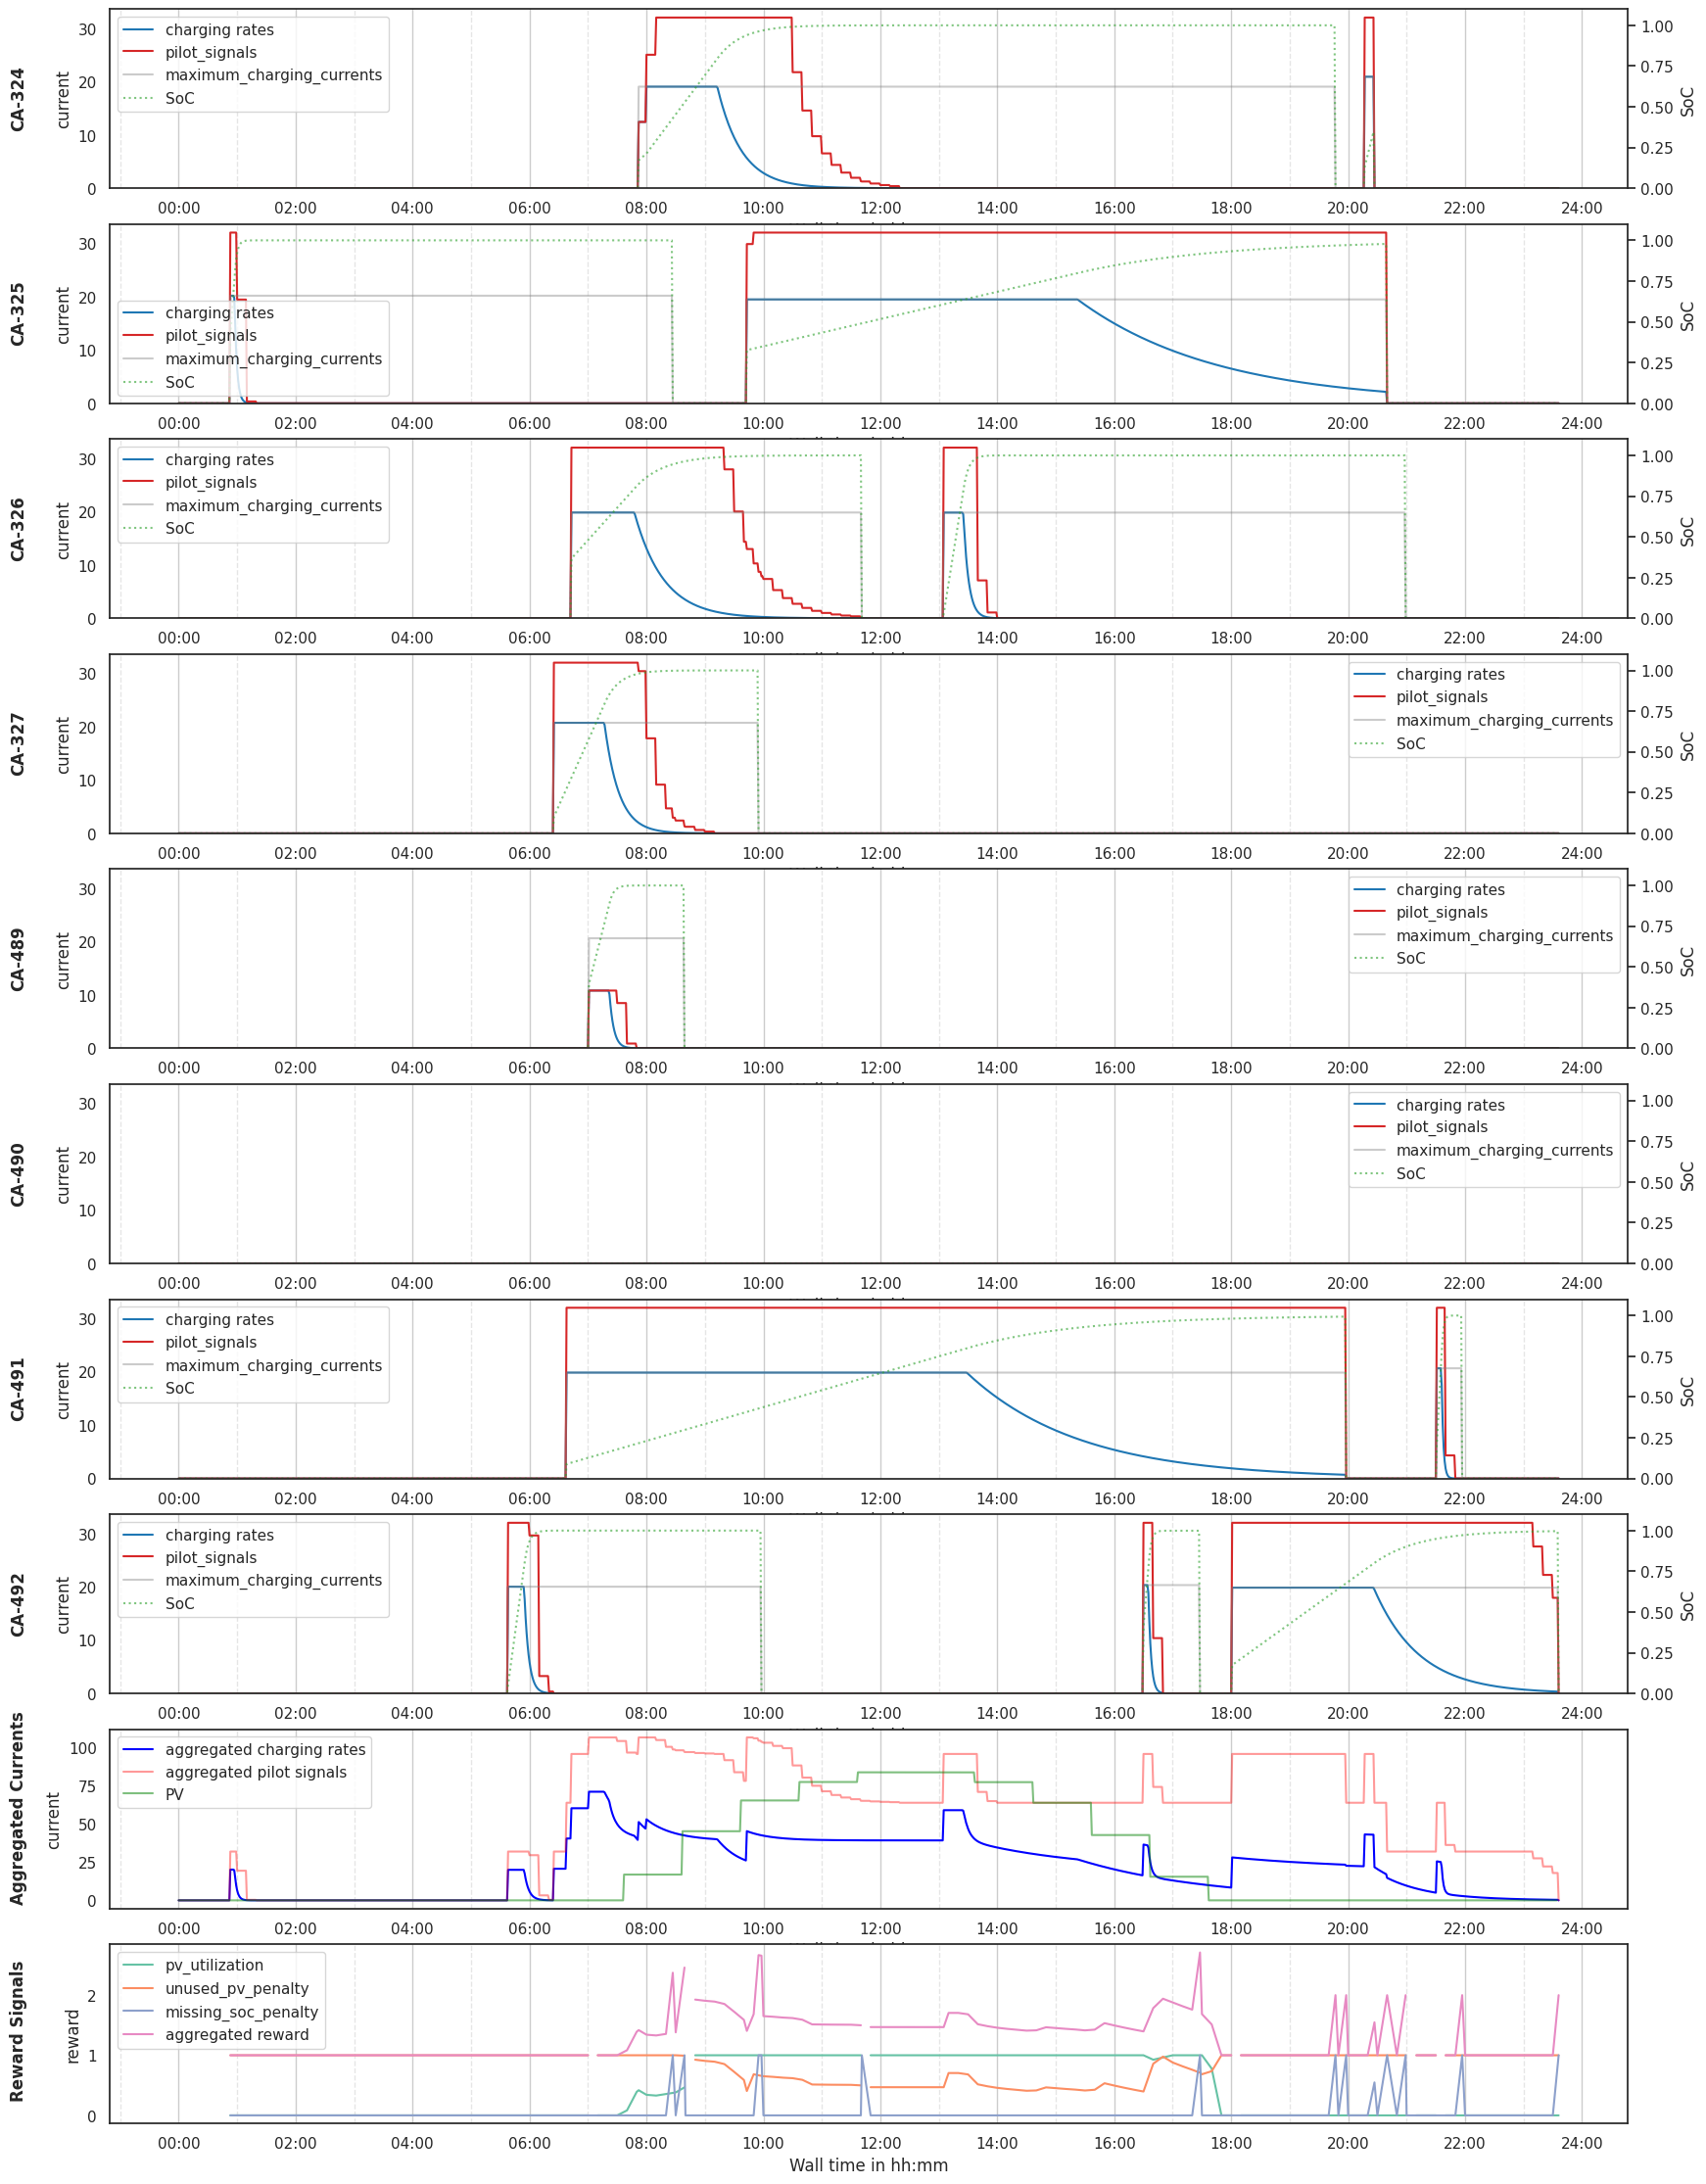

In [ ]:
from src.plotting import plot_sim_evaluation_pv

sim = simulations["FCFS"][0]
_ = plot_sim_evaluation_pv(sim, df_pv)